# Problem 1
## Parzen Window

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

In [ ]:
file_name = ''
def read_data(file_name=None, dataset_name=None):
  if file_name is None:
    # read dataset if dataset_name provided
    if dataset_name is not None:
      return sns.load_dataset(dataset_name)
  else:
    return pd.read_csv(file_name)

In [ ]:
data = read_data(dataset_name='iris')
rows_count, columns_count = data.shape
#Use scikit learn train test split to remove 20 percent of the data for testing. The API shuffle the data by default and selects the different sets randomly.
train_features, test_features, train_classes, test_classes = train_test_split(
    data.values[:, 0: columns_count-1], data.values[:, -1], test_size = 0.2, random_state=42)

In [ ]:
print(train_features.shape)
print(test_features.shape)
print(train_classes.shape)
print(test_classes.shape)

(120, 4)
(30, 4)
(120,)
(30,)


In [ ]:
def parzen_window(features, h):
  ''' Defines a single class parzen window with a Gaussian kernel. '''
  return KernelDensity(kernel='gaussian', bandwidth=h).fit(features)

We can test ```parzen_window(features, h)``` with the Iris data Versicolor class. You will notice that the KDE outputs high values for observations that belong to the Versicolor class. When a KDE outputs high likelihood values for an observation it shows that the observation has a high probability of being in that class.

In [ ]:
versicolor = data[data['species']=='versicolor']

kde = parzen_window(versicolor.values[:,0:4], 0.25);
print("kde output: {}, class label: {}".format(kde.score_samples(test_features[0].reshape(1,-1)), test_classes[0]))
print("kde output: {}, class label: {}".format(kde.score_samples(test_features[1].reshape(1,-1)), test_classes[1]))
print("kde output: {}, class label: {}".format(kde.score_samples(test_features[4].reshape(1,-1)), test_classes[4]))
print("kde output: {}, class label: {}".format(kde.score_samples(test_features[5].reshape(1,-1)), test_classes[5]))
print("kde output: {}, class label: {}".format(kde.score_samples(test_features[6].reshape(1,-1)), test_classes[6]))

kde output: [-0.68896743], class label: versicolor
kde output: [-37.08052568], class label: setosa
kde output: [-0.81016183], class label: versicolor
kde output: [-31.16250375], class label: setosa
kde output: [-1.16630123], class label: versicolor


In [ ]:
def multi_class_parzen_window(features_by_classes, h):
  ''' Defines a multiclass parzen window.

  Args: 
  features_by_classes: A list of features that are grouped by the target classes.
  h: The bandwidth of the parzen window.
  
  Returns:
  The  KDE for each class.
  '''
  kdfs = []
  for features in features_by_classes:
    kdfs.append(KernelDensity(kernel='gaussian', bandwidth=h).fit(features))
  return kdfs

setosa_features = train_features[np.where(train_classes == 'setosa')]
versicolor_features = train_features[np.where(train_classes == 'versicolor')]
virginica_features = train_features[np.where(train_classes == 'virginica')]

kdfs = multi_class_parzen_window([setosa_features, versicolor_features, virginica_features], 0.1)

In [ ]:
import operator
def predict(test_features, test_classes, kdfs):
  ''' Predicts the class the test observations belong to using the kernel densities provided. '''
  predictions = []
  for index, feature in enumerate(test_features):
    logs = []
    for kdf in kdfs:
      logs.append(kdf.score_samples(feature.reshape(1, -1))[0])
    prediction = get_max(logs);
    predictions.append(prediction)
  return predictions
  
def get_max(input):
    flowers = ["setosa", "versicolor", "virginica"]
    index, _ = max(enumerate(input), key=operator.itemgetter(1))
    return flowers[index]



In [ ]:
predictions = predict(test_features, test_classes, kdfs)
accuracy = np.count_nonzero((predictions == test_classes)== True)/len(test_classes)
print(predictions)
print(test_classes)
print('accuracy: ', accuracy)

['versicolor', 'setosa', 'virginica', 'versicolor', 'versicolor', 'setosa', 'versicolor', 'virginica', 'versicolor', 'versicolor', 'virginica', 'setosa', 'setosa', 'setosa', 'setosa', 'versicolor', 'virginica', 'versicolor', 'versicolor', 'virginica', 'setosa', 'virginica', 'setosa', 'virginica', 'virginica', 'virginica', 'virginica', 'virginica', 'setosa', 'setosa']
['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor' 'virginica' 'setosa'
 'setosa' 'setosa' 'setosa' 'versicolor' 'virginica' 'versicolor'
 'versicolor' 'virginica' 'setosa' 'virginica' 'setosa' 'virginica'
 'virginica' 'virginica' 'virginica' 'virginica' 'setosa' 'setosa']
accuracy:  1.0


Here the KDEs were good enough to predict the target classes for the tests perfectly as shown in the accuracy above.

**Runtime Analysis**
  
  The steps for the above system include:
*   Reading the data
*   Shuffling the data and then splitting it into train set and test set
*   Creating the Gaussian kernel
*   Fitting the Gaussian Kernel
*   Using the Gaussian Kernel to get the log probability density of a certain data point and comparing the results to the actual classification

We can say that reading the data takes ```c1*N```  work where N is the total amount of data available. The next step, Shuffling and splitting the data uses the scikit learn built in libraray train_test_split. Inspecting the code for that we see that it boils down to using numpy's [```np.random.RandomState.permutation```](https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.RandomState.permutation.html#numpy.random.RandomState.permutation). I was not able to find the implementation of this function but one could assume that this could be a simple implementation of using a random number generator N times in the range of N to generate numbers which would later be split in the percentage needed for the train and test sets. From the scipy code this is simply taking the first n_train (number items to be in train set) indices for the train set and using the remaining for the test set after the initial shuffle. So shuffle could be said to be ```c2 * N```. Creating the Gaussian Kernel takes constant time. It simply initializes the values we would use later in fiting and scoring the data [source code](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/neighbors/_kde.py#L94). Fitting also does more initializing by picking the algorithm and initializing for later use. To get the log probability density, we then apply the algorithm. For analysis we can assume it is the same as Equation 24 in the machine learning PDF. The things that determine the complexity for that equation would be the denominator where we multiply some constants D times (D is equivalent to the number of classes) and then do the D times multiplication N times, giving us work of ```C5 *D *N```.
```T(n) = c1*N + c2*N +c3 + c4 + c5*D*N``` giving us ```O(D*N)```.
Comparing T(n) to Big O we see that the scoring part which occurs in testing takes the most time.

(Please note I am doing the above estimation for a single class estimator, if it were to be multiple then we would create multiple estimators making the final runtime ```O(D^2 *N)``` )





**Reproduce Graphs:**

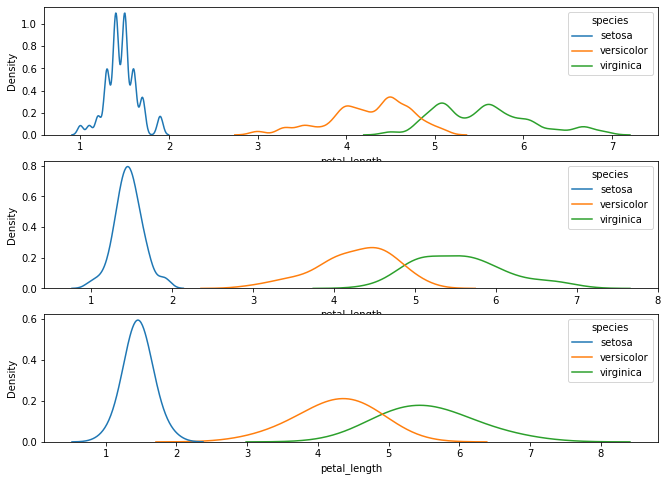

In [ ]:
data = read_data(dataset_name='iris')
fig, axs = plt.subplots( 3, 1, figsize=(11,8))
sns.kdeplot(data=data, x='petal_length', hue='species', bw_adjust = 0.1 * 4, ax = axs[0])
sns.kdeplot(data=data, x='petal_length', hue='species', bw_adjust = 0.25 * 4, ax = axs[1])
sns.kdeplot(data=data, x='petal_length', hue='species', bw_adjust = 0.5 * 4, ax = axs[2])

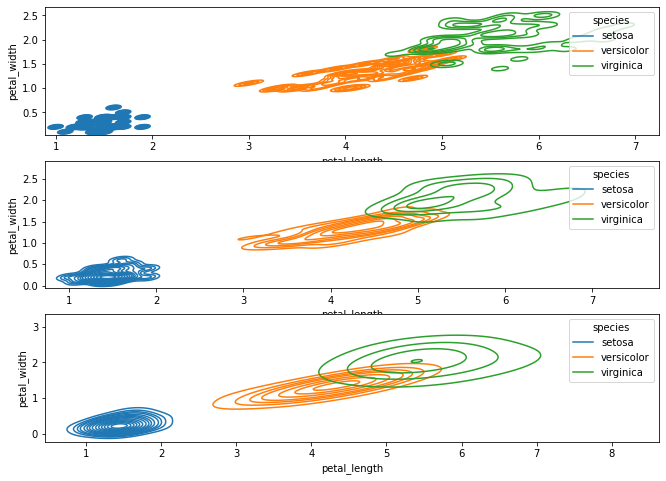

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(11,8))
sns.kdeplot(data=data, x='petal_length', y = 'petal_width', hue='species', bw_adjust = 0.1 * 4, levels=15, ax=axs[0])
sns.kdeplot(data=data, x='petal_length', y = 'petal_width', hue='species', bw_adjust = 0.25 * 4, levels=15, ax=axs[1])
sns.kdeplot(data=data, x='petal_length', y = 'petal_width', hue='species', bw_adjust = 0.5 * 4, levels=15, ax=axs[2])

#  Problem 2
## Support Vector Machines (SVM)

Reusing the read data, train and test split from problem 1 we fit a support vector machine with a Gaussian kernel.

In [ ]:
from sklearn import svm
# Create SVM and fit the training set.
clf_ovr = svm.SVC()
clf_ovr.fit(train_features, train_classes)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# See how the test set does in the trained SVM 
predictions = clf_ovr.predict(test_features)

In [ ]:
# Compare predictions
print(test_classes)
print(predictions)

['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor' 'virginica' 'setosa'
 'setosa' 'setosa' 'setosa' 'versicolor' 'virginica' 'versicolor'
 'versicolor' 'virginica' 'setosa' 'virginica' 'setosa' 'virginica'
 'virginica' 'virginica' 'virginica' 'virginica' 'setosa' 'setosa']
['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor' 'virginica' 'setosa'
 'setosa' 'setosa' 'setosa' 'versicolor' 'virginica' 'versicolor'
 'versicolor' 'virginica' 'setosa' 'virginica' 'setosa' 'virginica'
 'virginica' 'virginica' 'virginica' 'virginica' 'setosa' 'setosa']


In [ ]:
accuracy = np.count_nonzero((test_classes == predictions) == True)/len(test_classes)
print("prediction accuracy:", accuracy)

prediction accuracy: 1.0


The SVM's accuracy is equally perfect for this training set.

**Runtime Analysis**
  The steps for the above system include:
*   Reading the data
*   Shuffling the data and then splitting it into train set and test set
*   Creating the Support Vector Machine(SVM)
*   Fitting the SVM
*   Using the SVM to get the predicted class of test observations and comparing them to the actual classification.

As in Problem 1 reading and shuffling & splitting the data takes the same work (we reused the same functions). The creation of the SVM takes constant time. Here we use scikit-learns's [SVC](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/svm/_classes.py#L428) and according to the documentation it seems to take at least quadratic time to fit the data, with this in mind we will assume ```c6*N^2``` work for fitting. Looking through the source code it seems predict goes all the down to (here)[https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/svm/_libsvm_sparse.pyx#L223]. It seems scikit-learn uses libsvm underneath and from what I see so far I will assume a constant time work for predictions for a single class model and for multiclass, assuming one vs the rest, I will assume that there will be D calls to get the best fit and prediction for any input data.
 This give us:
```T(n) = c1*N + c2*N +c3 + c6*N^2 + c7``` for single class predictions and
```T(n) = c1*N + c2*N +c3 + c6*D*N^2 + c7*D``` for multiclass predictions.
Giving us ```O(N^2)``` for single class and ```O(D*N^2)``` for multiclass.

Comparing the T(n) to the Big O it seems that it takes more work to fit data and less to predict/test the data.

# Problem 3
## Neural Networks

In [ ]:
import tensorflow as tf
(train_features, train_targets), (test_features, test_target) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
print(train_features.shape)
print(test_features.shape)

(60000, 28, 28)
(10000, 28, 28)


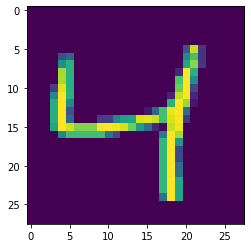

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_features[2, :, :])

Using a feed forward neural network to generate 12 features for the images.

In [ ]:
ff_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(12,activation='relu', name='feature_layer'),
  tf.keras.layers.Dense(10, activation='softmax')
])

ff_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
feature_layer (Dense)        (None, 12)                1548      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
Total params: 102,158
Trainable params: 102,158
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ff_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Training the model for a few epochs so we can have good enough weights for feature extraction
ff_model.fit(train_features, train_targets, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0471 - accuracy: 0.3485
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1976 - accuracy: 0.5481
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9688 - accuracy: 0.6283
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7037 - accuracy: 0.7432
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4528 - accuracy: 0.8500
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2805 - accuracy: 0.9225
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1825 - accuracy: 0.9537
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1447 - accuracy: 0.9626
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1224 - accuracy: 0.9679
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.109

In [ ]:
# Create feature extractor from the feature_layer in the feed forward model
feature_extractor = tf.keras.Model(inputs=ff_model.input,
                                       outputs=ff_model.get_layer('feature_layer').output)

feature_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_input (InputLayer)   [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
feature_layer (Dense)        (None, 12)                1548      
Total params: 102,028
Trainable params: 102,028
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Generate features for the first 1000 in train_features.
feature_extractor(train_features[0:1000])

<tf.Tensor: shape=(1000, 12), dtype=float32, numpy=
array([[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
        407.83392],
       [  0.     , 250.95561, 408.25815, ...,   0.     ,   0.     ,
          0.     ],
       ...,
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
        276.8459 ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     , 374.44098,   0.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)>

Now we shall try using a Convolutional Neural Network to generate 12 features

In [ ]:
conv_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2, 3, activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(12,activation='relu', name='feature_layer'),
  tf.keras.layers.Dense(10, activation='softmax')
])

conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 2)         20        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1352)              0         
_________________________________________________________________
feature_layer (Dense)        (None, 12)                16236     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                130       
Total params: 16,386
Trainable params: 16,386
Non-trainable params: 0
_________________________________________________________________


In [ ]:
expanded_train_features = np.expand_dims(train_features, -1)
expanded_train_features[0].shape

(28, 28, 1)

In [ ]:
conv_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Training the model for a few epochs so we can have good enough weights for feature extraction
conv_model.fit(expanded_train_features, train_targets, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3013 - accuracy: 0.3010
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4841 - accuracy: 0.4351
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1056 - accuracy: 0.5886
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4437 - accuracy: 0.8700
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2204 - accuracy: 0.9361
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1825 - accuracy: 0.9468
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1649 - accuracy: 0.9518
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1495 - accuracy: 0.9557
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1422 - accuracy: 0.9579
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.135

In [ ]:
conv_model.evaluate(np.expand_dims(test_features, -1), test_target)

313/313 [==============================] - 1s 2ms/step - loss: 0.1671 - accuracy: 0.9516


[0.16711431741714478, 0.9516000151634216]

In [ ]:
# Create feature extractor from the feature_layer in the feed forward model
feature_extractor = tf.keras.Model(inputs=conv_model.input,
                                       outputs=conv_model.get_layer('feature_layer').output)

feature_extractor.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 2)         20        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1352)              0         
_________________________________________________________________
feature_layer (Dense)        (None, 12)                16236     
Total params: 16,256
Trainable params: 16,256
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Generate features for the first 1000 in train_features.
feature_extractor(train_features[0:1000])

<tf.Tensor: shape=(1000, 12), dtype=float32, numpy=
array([[ 31.078487,   0.      ,   0.      , ...,   0.      ,   0.      ,
        109.39581 ],
       [  0.      ,   0.      ,  16.941782, ...,   0.      ,   0.      ,
         66.34788 ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [ 46.074875,   0.      ,   0.      , ...,   0.      ,   0.      ,
        110.16416 ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)>

We can add a softmax layer to either of the networks to see how well they classify the data. I will use the feed forward network here.

In [ ]:
ff_model.evaluate(test_features, test_target)

313/313 [==============================] - 1s 2ms/step - loss: 0.1662 - accuracy: 0.9580


[0.1661786437034607, 0.9580000042915344]

The Feed forward network classifies about 96% of the test set correctly.